# Computer Vision - Exercise 8
FIRSTNAME LASTNAME

## Task 1

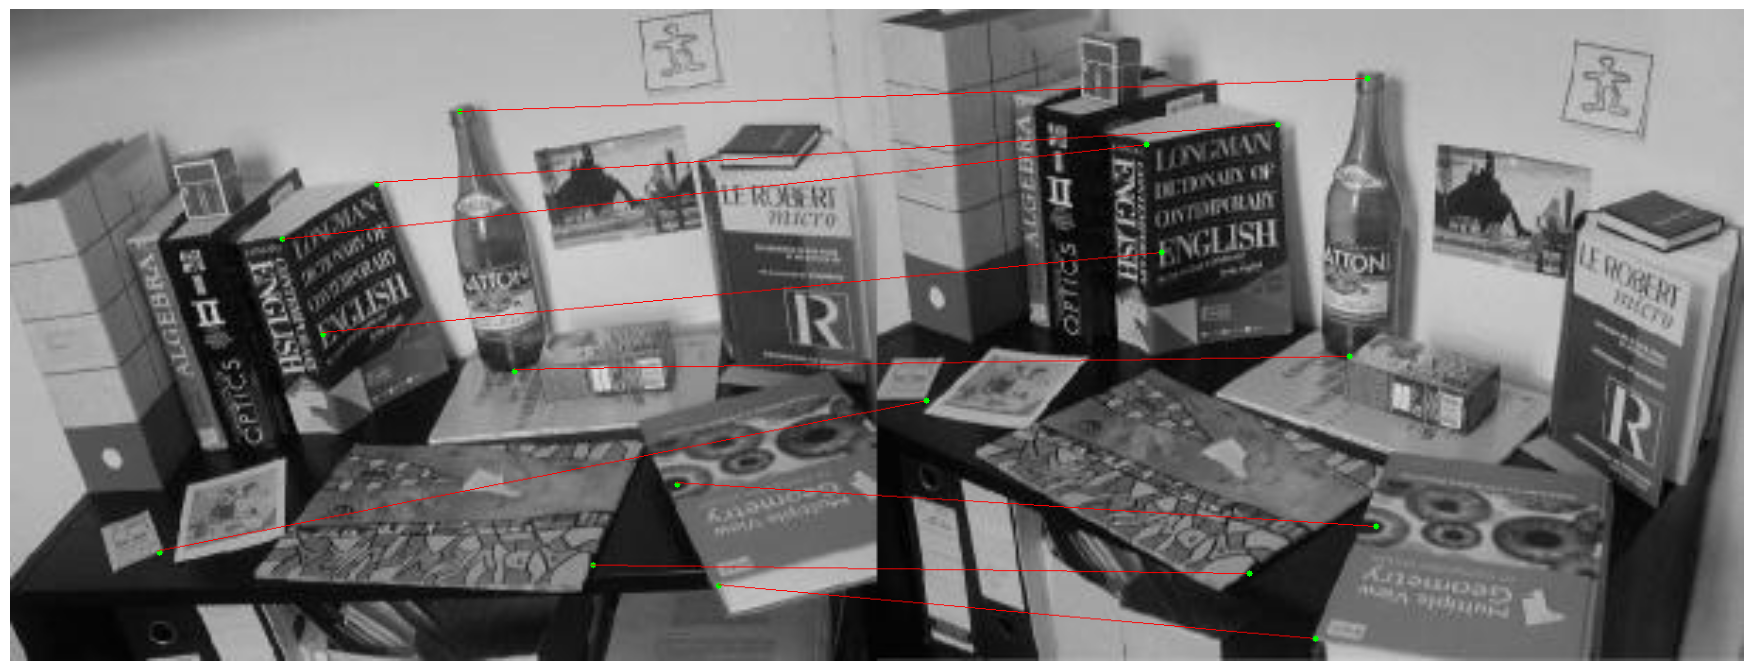

[(158, 36), (178, 127), (110, 114), (129, 61), (235, 167), (250, 203), (52, 191), (96, 81), (205, 196)]
[(173, 24), (166, 122), (100, 85), (141, 40), (176, 182), (154, 222), (17, 138), (95, 47), (131, 199)]


In [1]:
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np

def select_points(img1, img2, scale_factor=3):
    """Function to select points from an image.
    
    First select a point from the left, then from the right. If you selected all the points you wanted, press Esc or close the window.
    """
    points1 = []
    points2 = []
    count = 0  # Use a list to make count mutable within the nested function

    def click_event(event, x, y, flags, param):
        nonlocal count
        if event == cv.EVENT_LBUTTONDOWN:
            cmod = count % 2
            if not ((cmod == 0 and x < new_width // 2) or (cmod == 1 and x >= new_width // 2)):
                return

            original_x = int((x - new_width // 2 * cmod) / scale_factor)
            original_y = int(y / scale_factor)
            if cmod == 0:
                points1.append((original_x, original_y))
            else:
                points2.append((original_x, original_y))
                startpt = (points1[-1][0] * scale_factor, points1[-1][1] * scale_factor)
                cv.line(param, startpt, (x, y), (0, 0, 255), 1)

            cv.circle(param, (x, y), 3, (0, 255, 0), -1)
            cv.imshow("Image", param)
            count += 1

    # Load image
    img = np.concatenate((img1, img2), axis=1)

    # Resize image for display
    height, width = img.shape
    new_height, new_width = int(height * scale_factor), int(width * scale_factor)
    resized_img = cv.cvtColor(cv.resize(img, (new_width, new_height), interpolation=cv.INTER_LINEAR), cv.COLOR_GRAY2BGR)

    cv.imshow("Image", resized_img)
    cv.setMouseCallback("Image", click_event, resized_img)

    # Stop when esc pressed
    while True:
        key = cv.waitKey(20) & 0xFF
        if key == 27:  # ESC key to break
            break
        if cv.getWindowProperty("Image", cv.WND_PROP_VISIBLE) < 1:  # Check if window is closed
            break
    cv.destroyAllWindows()

    plt.figure(figsize=(18, 9))
    plt.imshow(cv.cvtColor(resized_img, cv.COLOR_BGR2RGB))
    plt.tight_layout()
    plt.axis("off")
    plt.show()
    return points1, points2


# TODO: Select points
img1 = cv.imread("books1.jpg", cv.IMREAD_GRAYSCALE)
img2 = cv.imread("books2.jpg", cv.IMREAD_GRAYSCALE)

# Select points
points1, points2 = select_points(img1, img2)
print(points1)
print(points2)

#### Functions to build all matrice

In [2]:
# TODO: expand and normalize points

def norm_points(points):
    """Expand and normalize points to improve numerical stability."""
    points = np.array(points)
    mean = np.mean(points, axis=0)
    std = np.std(points)
    T = np.array([[1/std, 0, -mean[0]/std], 
                  [0, 1/std, -mean[1]/std], 
                  [0, 0, 1]])
    
    points_h = np.column_stack((points, np.ones(len(points))))
    norm_points = (T @ points_h.T).T
    return norm_points[:, :2], T


# TODO: Build matrix A
def build_matrix_A(points1, points2):
    """Construct matrix A using normalized points."""
    A = []
    for (x1, y1), (x2, y2) in zip(points1, points2):
        A.append([x1*x2, x1*y2, x1, y1*x2, y1*y2, y1, x2, y2, 1])
    return np.array(A)

# TODO: Compute F from A
def compute_fundamental_matrix(A):
    """Compute F from matrix A using SVD."""
    U, S, Vt = np.linalg.svd(A)
    F = Vt[-1].reshape(3, 3)
    return F



# TODO: Compute F_dash from F. Make sure you know what np.linalg.svd returns
def enforce_rank_2(F):
    """Compute F' by enforcing rank-2 constraint on F."""
    U, S, Vt = np.linalg.svd(F)
    S[-1] = 0  # Force the smallest singular value to zero
    F_dash = U @ np.diag(S) @ Vt
    return F_dash

In [3]:
norm_p1, T1 = norm_points(points1)
norm_p2, T2 = norm_points(points2)

In [4]:
norm_p2.shape, T1.shape

((9, 2), (3, 3))

In [5]:
# Build matrix A using first 8 points
A = build_matrix_A(norm_p1[:8], norm_p2[:8])
A.shape

(8, 9)

In [6]:
# Compute fundamental matrix
F = compute_fundamental_matrix(A)
F.shape

(3, 3)

In [7]:
# Enforce rank-2 constraint
F_dash = enforce_rank_2(F)

In [8]:
# Denormalize fundamental matrix

F_final = T2.T @ F_dash @ T1
F_final

array([[ 1.50481555e-05, -3.94440606e-05, -1.73410176e-03],
       [ 3.81161331e-05,  3.11981998e-05, -2.06629333e-02],
       [-6.20528214e-03,  1.23756693e-02,  1.19777221e+00]])

In [9]:
# Verify with the ninth point
pL = np.array([*points1[8], 1])
pR = np.array([*points2[8], 1])
error = pR.T @ F_final @ pL

print("Fundamental Matrix:\n", F_final)
print("Error for the ninth point:", abs(error))

Fundamental Matrix:
 [[ 1.50481555e-05 -3.94440606e-05 -1.73410176e-03]
 [ 3.81161331e-05  3.11981998e-05 -2.06629333e-02]
 [-6.20528214e-03  1.23756693e-02  1.19777221e+00]]
Error for the ninth point: 0.17538425123939616


# Task 2

The left epipolar is: [440.52787365 124.1005642    1.        ]  and the right epipolar is: [337.21731006  29.66679841   1.        ]


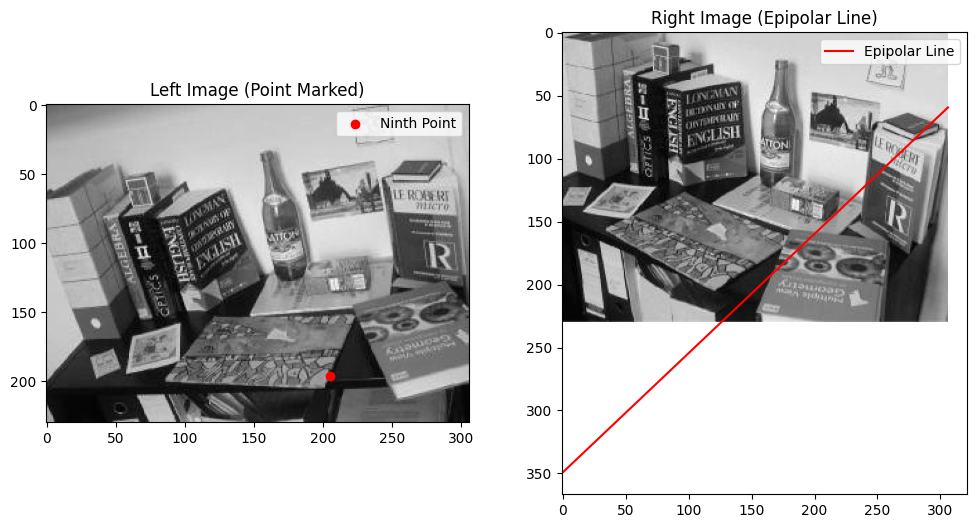

In [10]:
# TODO Use F to find left and right epipoles
def compute_epipoles(F):
    """Find the left and right epipoles from the fundamental matrix F."""
    U, S, Vt = np.linalg.svd(F)
    e_left = Vt[-1]  # Right null space of F (left image epipole)
    e_right = U[:, -1]  # Left null space of F (right image epipole)
    
    # Normalization
    e_left /= e_left[-1]
    e_right /= e_right[-1]
    
    return e_left, e_right

def compute_epipolar_line(F, point):
    """Compute the epipolar line l' in the right image given point p in the left image."""
    p_h = np.array([*point, 1])  # Convert to homogeneous coordinates
    line = F @ p_h  
    return line

# Compute epipoles
eL, eR = compute_epipoles(F_final)
print('The left epipolar is:', eL,' and the right epipolar is:', eR)

# TODO Plot the ninth point to the left image and right epipolar line to right
# Find the line coefficients from F @ el and plot the line

ninth_point_left = points1[8]  # Ninth point in left image
epipolar_line_right = compute_epipolar_line(F_final, ninth_point_left)

# Plot images and epipolar geometry
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot left image with the ninth point
ax[0].imshow(img1, cmap="gray")
ax[0].scatter(ninth_point_left[0], ninth_point_left[1], color='red', marker='o', label="Ninth Point")
ax[0].set_title("Left Image (Point Marked)")
ax[0].legend()

# Plot right image with the epipolar line
ax[1].imshow(img2, cmap="gray")

# Epipolar line equation: ax + by + c = 0
a, b, c = epipolar_line_right
x_vals = np.array([0, img2.shape[1]])  # Image width limits
y_vals = (-a * x_vals - c) / b  # Solve for y

# Plot the epipolar line
ax[1].plot(x_vals, y_vals, 'r', label="Epipolar Line")
ax[1].set_title("Right Image (Epipolar Line)")
ax[1].legend()

plt.show()
